# Intro to the object cell project!

## Wrangling

First, let's wrangle some data from Nagelhus: https://search.kg.ebrains.eu/?category=Dataset&q=moser%20rat#0162668e-bef0-4754-8562-40440db5bc0c


I've saved it in my downloads folder. You can open it like so:

In [4]:
from scipy.io import loadmat
data = loadmat("/home/nolanlab/Downloads/singlecellanalyses_CA1.mat")

Here's a function which reads in a "trial" from this data, and makes a "session" thy way I'd like it (not too bad, wrangling-wise):

In [2]:
import pynapple as nap
import numpy as np
from object_scores.core import SingleSession, SessionGroup

def session_from_trial(trial):

    try: 
        object_position = trial[3][0]['x'][0][0][0], trial[3][0]['y'][0][0][0]
    except:
        object_position = None

    positions = trial[1]
    x = np.transpose(positions['x'][0][0])[0]
    y = np.transpose(positions['y'][0][0])[0]
    timestamps = np.transpose(positions['timestamp'][0][0])[0]

    Px = nap.Tsd(timestamps, x)
    Py = nap.Tsd(timestamps, y)

    spikes_np = [np.transpose(spike_train[0])[0] for spike_train in trial[4][0]]

    spikes = nap.TsGroup(spikes_np)

    return SingleSession(spikes, Px, Py, object_position)

Now take three trials from one day, and make three "sessions" of them by using this newly written function

In [7]:
session_index = 0
rat_25224 = data['dataset'][0]['sessions'][0][0][session_index]

no_object_trial = rat_25224[2][0][0]
object_trial = rat_25224[2][0][1]
moved_trial = rat_25224[2][0][2]

no_object_session = session_from_trial(no_object_trial)
object_session = session_from_trial(object_trial)
moved_session = session_from_trial(moved_trial)

nagelhus_day = SessionGroup({'no_object': no_object_session, 'object': object_session, 'moved': moved_session})

/tmp/ipykernel_798579/3637221943.py:22: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  spikes = nap.TsGroup(spikes_np)


Ok - that's all the wrangling. Now we compute scores. Each score, e.g. the Object Responsiveness Index (ori) score, has a, e.g. `compute_ori` method and a `plot_ori` method. These methods have a simple structure: they check if they have the appropriate sessions to compute the score, then grab all data needed to compute the score from the `SessionGroup` object, then compute. Let's compute stuff:

In [9]:
nagelhus_day.compute_ori()
nagelhus_day.compute_information_content()
nagelhus_day.compute_increase()

/home/nolanlab/Work/Developing/fromgit/object-scores/src/object_scores/scores.py:38: RuntimeWarning: divide by zero encountered in log2
  prob_of_occupancy*normalised_firing_rate*np.log2(normalised_firing_rate)
/home/nolanlab/Work/Developing/fromgit/object-scores/src/object_scores/scores.py:38: RuntimeWarning: invalid value encountered in multiply
  prob_of_occupancy*normalised_firing_rate*np.log2(normalised_firing_rate)
/home/nolanlab/Work/Developing/fromgit/object-scores/src/object_scores/scores.py:38: RuntimeWarning: divide by zero encountered in log2
  prob_of_occupancy*normalised_firing_rate*np.log2(normalised_firing_rate)
/home/nolanlab/Work/Developing/fromgit/object-scores/src/object_scores/scores.py:38: RuntimeWarning: invalid value encountered in multiply
  prob_of_occupancy*normalised_firing_rate*np.log2(normalised_firing_rate)
/home/nolanlab/Work/Developing/fromgit/object-scores/src/object_scores/scores.py:38: RuntimeWarning: divide by zero encountered in log2
  prob_of_occu

({np.int64(0): np.float64(0.38915982114151837),
  np.int64(1): np.float64(0.8246397957748226),
  np.int64(2): np.float64(0.9060824223161623)},
 {np.int64(0): array([[-0.3229756 ,  0.6614878 ,  0.3385122 ],
         [-0.96645595,  0.98322798,  0.01677202],
         [ 0.63826646,  0.18086677,  0.81913323],
         [ 0.21111727,  0.39444137,  0.60555863],
         [-0.53016778,  0.76508389,  0.23491611],
         [-0.97751158,  0.98875579,  0.01124421],
         [-0.85742145,  0.92871072,  0.07128928],
         [ 0.04384902,  0.47807549,  0.52192451],
         [ 0.9453811 ,  0.02730945,  0.97269055],
         [-0.89944526,  0.94972263,  0.05027737],
         [ 0.59932693,  0.20033654,  0.79966346],
         [ 0.44596692,  0.27701654,  0.72298346],
         [ 0.80704125,  0.09647938,  0.90352062],
         [ 0.76673138,  0.11663431,  0.88336569],
         [-0.95852701,  0.97926351,  0.02073649],
         [-0.98308614,  0.99154307,  0.00845693],
         [-0.73381876,  0.86690938,  0.13309

As you compute the scores, they get saved in your GroupSessions object (our one is `nagelhus_day`):

In [12]:
nagelhus_day.scores

,cluster_id,ori_object,ori_moved,information_content_no_object,information_content_object,information_content_moved
0,0,-0.874047,-0.574734,3.502477,4.336173,3.923782
1,1,-0.909399,-0.944267,7.134987,3.323480,4.605362
2,2,0.676320,0.587874,3.638364,1.917991,2.907924


I've tried to write plotting functions which demonstrate the basics of the score. You need to pass a `cluster_id`. Let's plot the `increase` visualisation. This score computes the firing rate near an object in a non-object trial and then an object trial, and computes how much firing changed. Then does this lots of times for shuffled data and tries to see if the increase is significant.

/home/nolanlab/Work/Developing/fromgit/object-scores/src/object_scores/scores.py:64: RuntimeWarning: invalid value encountered in scalar divide
  normalised_of_ratio = of_ratio/(of_ratio+obj_ratio)
/home/nolanlab/Work/Developing/fromgit/object-scores/src/object_scores/scores.py:65: RuntimeWarning: invalid value encountered in scalar divide
  normalised_obj_ratio = obj_ratio/(of_ratio+obj_ratio)


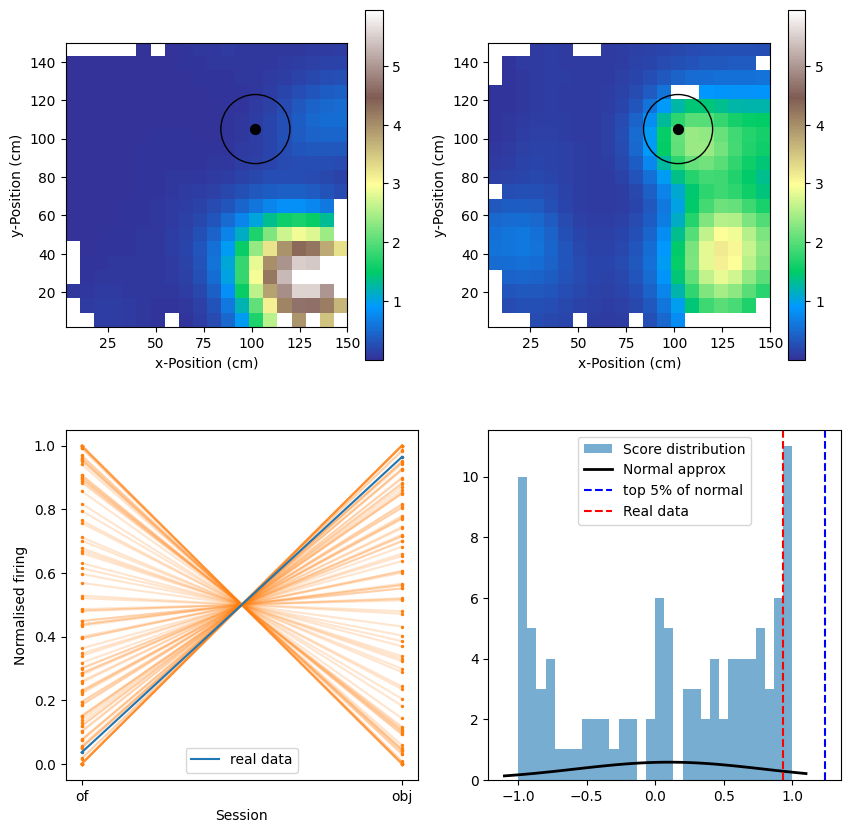

In [16]:
fig = nagelhus_day.plot_increase(cluster_id=2)

This plot makes us doubt the "normal" approximation we make for the score distribution... nice!